<a href="https://colab.research.google.com/github/jccrews256/ST-554-Project1-Template/blob/main/Task3/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Project 1_task3
Author: Joy Zhou
Reviewed by: Case Crews, Trevor Lillywhite
Date: 2/15/2026
```

In [ ]:
!git clone https://github.com/jccrews256/ST-554-Project1-Template.git

Cloning into 'ST-554-Project1-Template'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 128 (delta 13), reused 0 (delta 0), pack-reused 98 (from 2)
Receiving objects: 100% (128/128), 16.45 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (54/54), done.


# Introduction
We will work on `Air Quality`dataset avaiable on [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/360/air+quality). The dataset is a time-series dataset contains 9,358 hourly air-quality measurements records collected from March 2004 to February 2005 in an urban area in Italy. It includes the responses of five metal-oxide chemical sensors as well as ground-truth hourly concentrations of CO, non-methanic hydrocarbons, benzene, nitrogen oxides (NOx), and nitrogen dioxide (NO₂). Missing values in the dataset are encoded with -200.    
The related variables used in this study are provided below:   
C6H6(GT): True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)   
CO(GT): True hourly averaged CO concentration in mg/m^3 (reference analyzer)   
Date: MM/DD/YYYY   
Time: HH.MM.SS   
T: Temperature (°C)   
RH: Relative Humidity (%)   
AH: Absolute Humidity   


# Read in data and data cleaning

- Install the `ucimlrepo` library

In [1]:
!pip install ucimlrepo

In [3]:
# import key modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import ucimlrepo as uci
import datetime

- Read in data

In [4]:
#fetch dataset
air_quality = uci.fetch_ucirepo(id=360)
# data (as pandas dataframes)
df = air_quality.data.features
#check a few obs
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [ ]:
print(df.columns) #display the column names

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


We will remove any observations where `C6H6(GT)`, `CO(GT)`, `T`, `RH`, or `AH` have a value of -200, since this code represents missing data.
- we will first replace all -200 with NaN for cloumns `C6H6(GT)`, `CO(GT)`, `T`, `RH`, or `AH`, and subsequently remove the resulting missing values.

In [10]:
cols = ['C6H6(GT)', 'CO(GT)', 'T', 'RH', 'AH'] #columns to check
#replace missing value code(-200) with NaN in those columns
df[cols]= df[cols].replace(-200, np.nan)
# drop rows that have NaN in any of thse columns and explicitly make a copy
subset = df.dropna(subset=cols).copy()
#inspect the subset
subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7344 non-null   object 
 1   Time           7344 non-null   object 
 2   CO(GT)         7344 non-null   float64
 3   PT08.S1(CO)    7344 non-null   int64  
 4   NMHC(GT)       7344 non-null   int64  
 5   C6H6(GT)       7344 non-null   float64
 6   PT08.S2(NMHC)  7344 non-null   int64  
 7   NOx(GT)        7344 non-null   int64  
 8   PT08.S3(NOx)   7344 non-null   int64  
 9   NO2(GT)        7344 non-null   int64  
 10  PT08.S4(NO2)   7344 non-null   int64  
 11  PT08.S5(O3)    7344 non-null   int64  
 12  T              7344 non-null   float64
 13  RH             7344 non-null   float64
 14  AH             7344 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 918.0+ KB


- To create a new dataset with one row per day, we compute daily averages of C6H6(GT), CO(GT), T, RH, and AH. Tha main steps are:
    - We convert the Date column to a datetime type, ensuring pandas correctly interprets the MM/DD/YYYY format.
    - Standardize the Time column, replacing periods with colons so that all values follow the HH:MM:SS format.
    - The `Date_Time` column is created by combining the `Date` and `Time` columns to have a single, accurate timestamp for each hourly observation and facilites time-based operations.


In [11]:
# convert the Date column to datetime format
subset['Date'] = pd.to_datetime(subset['Date'], format='%m/%d/%Y')
# standardize the time format
subset['Time'] = subset['Time'].str.replace('.', ':', regex=False)
# create combined datetime variable
subset['Date_Time'] = subset['Date'] + pd.to_timedelta(subset['Time'])
# check dataset structure
subset.info()
subset.head() #check the first few obs

<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7344 non-null   datetime64[ns]
 1   Time           7344 non-null   object        
 2   CO(GT)         7344 non-null   float64       
 3   PT08.S1(CO)    7344 non-null   int64         
 4   NMHC(GT)       7344 non-null   int64         
 5   C6H6(GT)       7344 non-null   float64       
 6   PT08.S2(NMHC)  7344 non-null   int64         
 7   NOx(GT)        7344 non-null   int64         
 8   PT08.S3(NOx)   7344 non-null   int64         
 9   NO2(GT)        7344 non-null   int64         
 10  PT08.S4(NO2)   7344 non-null   int64         
 11  PT08.S5(O3)    7344 non-null   int64         
 12  T              7344 non-null   float64       
 13  RH             7344 non-null   float64       
 14  AH             7344 non-null   float64       
 15  Date_Time      7344 non-nu

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Date_Time
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00


- Then we group by `Date` and compute the mean of these five selected variables and store them to a new dataset `air_quality_clean`.

In [12]:
#calculate the mean of five variables and rename C6H6(GT) and CO(GT) columns
air_quality_clean = subset.groupby('Date')[['C6H6(GT)', 'CO(GT)', 'T', 'RH', 'AH']] \
                    .mean() \
                    .round(4) \
                    .rename(columns={'C6H6(GT)': 'benzene',
                                     'CO(GT)': 'CO'}
                            )

# create a new Day variable (1 to 347) in chronological order
air_quality_clean['Day'] = np.arange(1, len(air_quality_clean) + 1)
air_quality_clean.info() #check the new dataset structure
air_quality_clean.head() #check the first few obs

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2004-03-10 to 2005-04-04
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   benzene  347 non-null    float64
 1   CO       347 non-null    float64
 2   T        347 non-null    float64
 3   RH       347 non-null    float64
 4   AH       347 non-null    float64
 5   Day      347 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 19.0 KB


,benzene,CO,T,RH,AH,Day
Date,,,,,,
2004-03-10,8.4500,1.9667,12.0333,54.9000,0.7656,1
2004-03-11,8.2696,2.2391,9.8261,64.2304,0.7770,2
2004-03-12,12.1773,2.8045,11.6182,50.1909,0.6652,3
2004-03-13,11.1217,2.6957,13.1217,50.6826,0.7330,4
2004-03-14,9.8304,2.4696,16.1826,48.3174,0.8492,5


# Modeling
Cross-validation is used to evaluate how well a model generalizes to unseen data by repeatedly training and testing it on different subsets of the dataset. This helps prevent overfitting and provides a more reliable estimate of model performance. Classical cross-validation techniques assume that samples are independent and identically distributed (i.i.d.). However, time-series data violate this assumption because observations are ordered in time and exhibit autocorrelation. This means we cannot use standard cross-validation methods such as K-Fold, since they would mix past and future observations and produce misleading estimates of model performance. Instead, it is essential to evaluate time-series models on future observations that were not used for training ([Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/modules/cross_validation.html)).
Because our dataset is recorded over time, we will train and test the model sequentially rather than using random splits. The procedure is as follows:

- Use the first 250 days of data to fit the model, then predict day 251 and compute the MSE.
- Then use the first 251 days to fit the model, predict day 252 and compute the MSE.
- Continue this process by adding one more day of data to the training set, until reaching the final day.
- Finally, sum all step-ahead MSE values to obtain an overall measure of model performance.

This approach ensures that each prediction is truly out-of-sample and respects the time order of the data, providing a realistic assessment of the model's ability to generalize to future observations.


The `benzene (C6H6(GT))` serves as our response variable. we will first fit a Simple Linear Regression (SLR) model using `CO` to predict `benzene` level. In addition, we will fit a Multiple Linear Regression (MLR) model as a competitor by using `CO`, `temperature(T)`, `Relative Humidity(RH)`, and `Absolute Humidity(AH)` to predict `benzene`.


We first visualize the trend of benzene concentration over time to better understand its temporal structure before fitting any model.

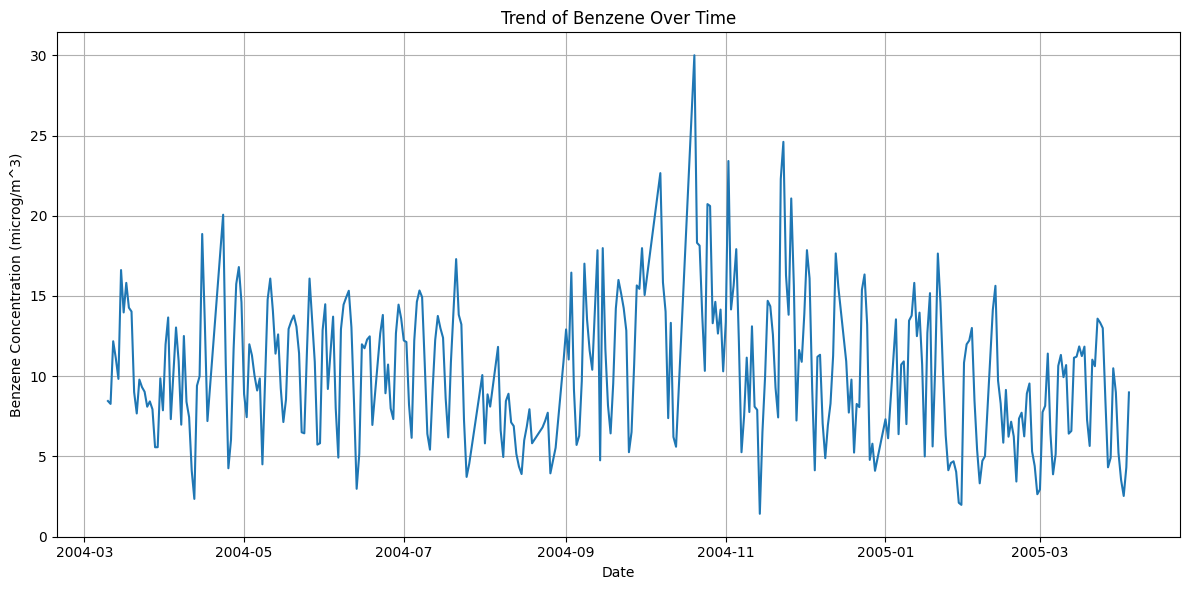

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the trend of benzene over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=air_quality_clean.index, y='benzene', data=air_quality_clean)
plt.title('Trend of Benzene Over Time')
plt.xlabel('Date')
plt.ylabel('Benzene Concentration (microg/m^3)')
plt.grid(True)
plt.tight_layout()

The plot shows the daily benzene concentration (C6H6(GT)) from March 2004 to April 2005. Overall, the series displays substantial short-term fluctuations, with concentrations frequently rising and falling from one day to the next. There is also evidence of broader temporal patterns: benzene levels tend to increase during the late fall and early winter months of 2004, with a noticeable peak around November. After this period, concentrations generally decline and show a lower, more stable pattern into early 2005.Such patterns highlight that benzene levels are influenced by both time and environmental conditions. These observations motivate the use of sequential training/testing and the inclusion of meteorological variables (CO, T, RH, AH) in our regression models.

We will write a function to get the MSE for one step walk-forward cross-validation
- Let's calculate the MSE for predicting day 251 using the first 250 days of data, for a Simple Linear Regression with CO as a predictor for benzene.

In [14]:
# one step Walk-forward cross-validation for Simple Linear Regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Split data into training and test sets for the first step (day 251 prediction)
# observations from day 1 up to day 250.
train_data = air_quality_clean.iloc[:250]
# Predict the next day
test_data = air_quality_clean.iloc[250:250+1]

# Prepare X and y for SLR
X_train_slr = train_data["CO"].values.reshape(-1, 1)
y_train_slr = train_data["benzene"].values
X_test_slr = test_data["CO"].values.reshape(-1, 1)
y_test_slr = test_data["benzene"].values

# Fit SLR model
reg_slr = linear_model.LinearRegression() #create a reg object
reg_slr.fit(X_train_slr, y_train_slr)

# Make prediction
y_predicted_slr = reg_slr.predict(X_test_slr)

# Calculate MSE for the prediction and add to list
mse_slr = mean_squared_error(y_test_slr, y_predicted_slr)

round(mse_slr, 4)

10.6681

- Then calculate the MSE for predicting day 251 using the first 250 days of data, for a Multiple Linear Regression with `CO`, `T`, `RH`, and `AH` as predictors for benzene.


In [15]:
# one day ahead cross-validation for Multiple Linear Regression (MLR)

# Define predictors for MLR
predictors = ["CO", "T", "RH", "AH"]

# Split data into training and test sets for the first step (day 251 prediction)
train_data = air_quality_clean.iloc[:250] #observations from day 1 up to day 250.
test_data = air_quality_clean.iloc[250:250+1] # Predict the next day

# Prepare X and y for MLR
X_train_mlr = train_data[predictors].values
y_train_mlr = train_data["benzene"].values
X_test_mlr = test_data[predictors].values
y_test_mlr = test_data["benzene"].values

# Fit MLR model
reg_mlr = linear_model.LinearRegression()
reg_mlr.fit(X_train_mlr, y_train_mlr)

# Make prediction
y_predicted_mlr = reg_mlr.predict(X_test_mlr)

# Calculate MSE for the prediction and add to list
mse_mlr = mean_squared_error(y_test_mlr, y_predicted_mlr)

print(round(mse_mlr, 4))

1.6318


We will wrap these steps to a function get_MSE for one day ahead prediction.

In [24]:
def get_MSE(df, response, *predictors, initial_day: int = 250):

    """
    Compute 1-step ahead MSE using a sequential,
    time-ordered cross-validation procedure.
    Expanding-window, 1-step-ahead walk-forward evaluation:
      - Fit on days [1..250] -> predict day 251
      - Fit on days [1..251] -> predict day 252
    """
    predictors = list(predictors)

    # Split data into training and test sets
    train_data = df.iloc[:initial_day]
    test_data = df.iloc[initial_day:initial_day+1] # Predict the next day

    # Prepare X and y
    if len(predictors) == 1:
        X_train = train_data[predictors].values.reshape(-1, 1)
        y_train = train_data[response].values
        X_test = test_data[predictors].values.reshape(-1, 1)
        y_test = test_data[response].values

    else:
        X_train = train_data[predictors].values
        y_train = train_data[response].values
        X_test = test_data[predictors].values
        y_test = test_data[response].values
    # Fit MLR model
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)

    # Make prediction
    y_predicted = reg.predict(X_test)

    # Calculate MSE for the prediction
    mse = mean_squared_error(y_test, y_predicted)
    return round(mse, 4)

In [25]:
#call the function for one day ahead prediction
get_MSE(air_quality_clean, "benzene", "CO")

10.6681

In [26]:
#call the function for on day 251
get_MSE(air_quality_clean, "benzene", "CO", initial_day=251)

22.5559

In [27]:
#call the function
get_MSE(air_quality_clean, "benzene", "CO", "T", "RH", "AH")

1.6318

In [22]:
#call the function on day 251
get_MSE(air_quality_clean, "benzene", "CO", "T", "RH", "AH", initial_day=251)

9.9

Then we will use get_MSE as a helper function to write a new function get_VC_error to find the cross validation error

In [31]:
def get_CV_error(df, response, *predictors, initial_day: int = 250):

    """
    Compute cumulative 1-step-ahead MSE using a sequential,
    time-ordered cross-validation procedure.

    At each step t, the model is trained on the first t days and used to
    predict day t+1 (i.e., walk-forward evaluation). The MSE for each step is
    obtained via `get_MSE` and accumulated across all steps from `initial_day`
    up to the penultimate day.

    Expanding-window, 1-step-ahead walk-forward evaluation:
      - Fit on days [1..250] -> predict day 251
      - Fit on days [1..251] -> predict day 252
    """
    total_mse = 0  # Initialize total MSE to 0
    predictors = list(predictors)

    for i in range(initial_day, len(df)-1):
        # Get one step ahead mse using the get_MSE function
        mse = get_MSE(df, response, *predictors, initial_day=i)
        total_mse += mse  # Add the current step's MSE to the total
    return round(total_mse, 4)

The function will first be executed using the SLR model.

In [29]:
#call get_CV_error function
get_CV_error(air_quality_clean, "benzene", "CO")

716.7593

Next, the function will be executed using the MLR model for comparison.

In [30]:
#call function
get_CV_error(air_quality_clean, "benzene", "CO", "T", "RH", "AH")

493.3591

The MSE of the MLR model is 493.3591, which is lower than that of the SLR model (716.7593). Therefore, the MLR model provides the better fit.

Because the MLR model was identified as the best model, it will be fitted to the full dataset.

In [32]:
from sklearn import linear_model
reg = linear_model.LinearRegression() #Create a reg object
reg.fit(air_quality_clean[["CO", "T", "RH", "AH"]],
        air_quality_clean["benzene"])

LinearRegression()

In [33]:
print(reg.intercept_, reg.coef_)

-1.8374722690346719 [ 4.77081687  0.11971146 -0.01620981  0.68906308]


# Fitted MLR model
$$
\hat{Y} = -1.83747
+ 4.77082(\text{CO})
+ 0.11971(\text{T})
- 0.01621(\text{RH})
+ 0.68906(\text{AH})
$$


Based on the refitted MLR model, `CO` and absolute humidity (`AH)` both have positive coefficients, indicating that higher `CO` levels and higher absolute humidity are associated with increased benzene concentrations. Temperature also shows a small positive effect. In contrast, relative humidity has a negative coefficient, suggesting that higher RH is associated with lower benzene levels when all other predictors are held constant.
